**Using GAN to upscale images**

main paper : 

https://arxiv.org/abs/1609.04802

additional:

1. Неясено назначение слоя с поэлементным суммированием.

НАЙДЕНО https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

2. pixelshuffle

https://arxiv.org/pdf/1609.05158.pdf

https://keras.io/examples/vision/super_resolution_sub_pixel/

3. Error

ResourceExhaustedError: Graph execution error:

что-то с дискриминатором
и странности и потерями
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=N0MqHFb4F_qn

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.22.0
ipywidgets       : 8.0.4
jupyter_client   : 8.2.0
jupyter_core     : 5.3.0
jupyter_server   : 2.10.0
jupyterlab       : 4.0.8
nbclient         : 0.8.0
nbconvert        : 7.11.0
nbformat         : 5.9.2
notebook         : 7.0.6
qtconsole        : not installed
traitlets        : 5.9.0


**IMPORTING LIBRARIES AND PACKAGES**

In [2]:
#visualization of data
from PIL import Image
import matplotlib.pyplot as plt 
#technical tool to for saving temporary files
import os
import datetime
import time
#main libraries
import numpy as np
import tensorflow as tf

#tuning

#prevent tensorflow from allocating all GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

print("GPU:", physical_devices)
print("TensorFlow version:", tf.__version__)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.10.1


**Settings**

In [3]:
#weight made by model.save_weights
load_weights = False
#weight made by tf.train.CheckpointManager
resotre_weights = True

#names for model.save_weights directive
weights_folder = "weights_modver/"
weights_file_index = "_main"

#
TRAINING = True

**LOADING DATASET**



**secondary functions**

In [4]:
#cuts the image into equal pieces
#currently not used
def parse(img, chunk, with_map=False):
    img_new = np.array(img)
    img_width = img_new.shape[0]
    img_height = img_new.shape[1]
    #print("shape", img_width, img_height)
    rows = img_height/chunk
    row_remainder = img_height%chunk
    columns = img_width/chunk
    column_remainder = img_width%chunk
    #print("remainders", row_remainder, column_remainder)
    rows, columns = int(rows), int(columns)
    start_r, start_c = int(row_remainder//2), int(column_remainder//2)
    #print("start position", start_r, start_c)

    img_new = [img_new[(start_c+j*chunk):(start_c+j*chunk)+chunk, 
                       (start_r+i*chunk):(start_r+i*chunk)+chunk] for i in range(rows) for j in range(columns)]
    if with_map:
        return({"img":img_new, "map":(rows,columns)})
    return img_new

#assemble an image from pieces
#currently not used
def rebuild_img(v0chunks, img_map):
    chunks = np.array(v0chunks)
    face = chunks.shape[-2]
    temp = np.zeros((face*img_map[-1], face*img_map[0],3))
    
    for y in range(img_map[-1]):
        for x in range(img_map[0]):
            temp[face*y:face*(y+1), face*x:face*(x+1)] = chunks[x*img_map[0]+y]
            
    temp = np.uint8(temp)
    
    assert (temp.shape[:-1] == np.array(img_map)*face).all
    
    return temp


# alternative downsample - Bicubic 
#currently not used
def bicubic_kernel(x, a=-0.5):
  if abs(x) <= 1:
    return (a + 2)*abs(x)**3 - (a + 3)*abs(x)**2 + 1
  elif 1 < abs(x) and abs(x) < 2:
    return a*abs(x)**3 - 5*a*abs(x)**2 + 8*a*abs(x) - 4*a 
  else:
    return 0
def build_filter(factor):
  size = factor*4
  k = np.zeros((size))
  for i in range(size):
    x = (1/factor)*(i- np.floor(size/2) +0.5)
    k[i] = bicubic_kernel(x)
  k = k / np.sum(k)
  # make 2d
  k = np.outer(k, k.T)
  k = tf.constant(k, dtype=tf.float32, shape=(size, size, 1, 1))
  return tf.concat([k, k, k], axis=2)
def apply_bicubic_downsample(x, filter, factor):
  """Downsample x by a factor of factor, using the filter built by build_filter()
  x: a rank 4 tensor with format NHWC
  filter: from build_filter(factor)
  factor: downsampling factor (ex: factor=2 means the output size is (h/2, w/2))
  """
  # using padding calculations from https://www.tensorflow.org/api_guides/python/nn#Convolution
  filter_height = factor*4
  filter_width = factor*4
  strides = factor
  pad_along_height = max(filter_height - strides, 0)
  pad_along_width = max(filter_width - strides, 0)
  # compute actual padding values for each side
  pad_top = pad_along_height // 2
  pad_bottom = pad_along_height - pad_top
  pad_left = pad_along_width // 2
  pad_right = pad_along_width - pad_left
  # apply mirror padding
  x = tf.pad(x, [[0,0], [pad_top,pad_bottom], [pad_left,pad_right], [0,0]], mode='REFLECT')
  # downsampling performed by strided conv
  x = tf.nn.depthwise_conv2d(x, filter=filter, strides=[1,strides,strides,1], padding='VALID')
  return x

#output image with matplotlib
def visualize(img_data, path=None): #input can be image or batch or tensorflow iterator
    temp = np.array(img_data)
    print(temp.shape)
    if len(temp.shape) < 4:
        temp = np.expand_dims(temp, 0)
    fig, ax = plt.subplots(ncols=len(temp), figsize=(10, 10), squeeze=False)
    for indx, img in enumerate(temp):
        ax[0][indx].imshow(img)

Found 3497 files belonging to 1 classes.
(2, 512, 512, 3)


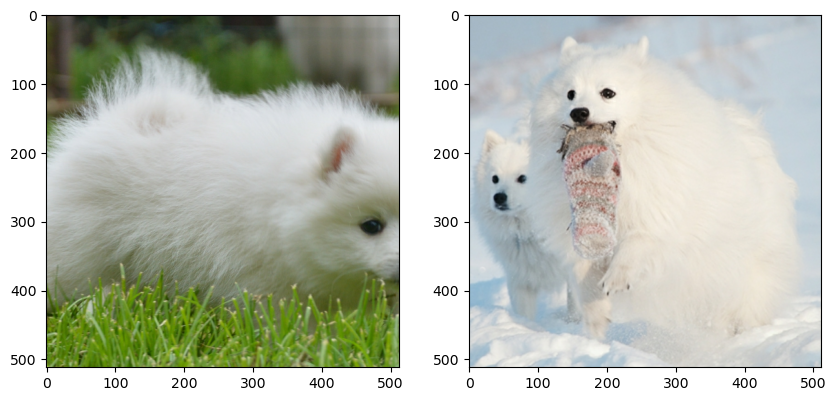

In [5]:
#seting data directory and createing dataset

DIRNAME = r"D:\dataset30102023\train"
#DIRNAME = r"C:\Users\common\source\Jupyter\GAN based image upscaling\mscoco\mscoco_resized\val2017"

if TRAINING == True:
    train_ds = tf.keras.utils.image_dataset_from_directory(DIRNAME,
                                                          image_size=(512,512),
                                                          labels=None,
                                                           batch_size=2,
                                                          crop_to_aspect_ratio=True)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x:normalization_layer(x))

    if True:
        test_sample = next(iter(train_ds))
        visualize(test_sample)

**CREATING GENERATOR MODEL**

* GAN uses two models, a generator model that generates output and a discriminator model that classifies wether the output is generated by the generator model(fake) or taken from the dataset(real)

* The generator model is a U-Net. It is a neural network used for image to image tasks. It has three major components : downsampling blocks, upsampling blocks and skip connections.

* Downsampling blocks convert image input to tensors of lower dimesions until it becomes a 1D tensor. Upsampling blocks convert output of downsampling blocks back to image output. Skip connections provide connections between downsampling and upsampling blocks at each level.

* Generator and discriminator compete against each other.

pixel shuffler 

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1609.05158.pdf


In [6]:
#repeatable generator part
def generator_block(filters, size, name=None):
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    #relu02= lambda x: tf.keras.activations.relu(x, alpha=0.2)
    
    result = tf.keras.Sequential(name=name)
    
    result.add(tf.keras.layers.Conv2D(filters, 
                                      size, 
                                      **conv_args)) 
    result.add(tf.keras.layers.BatchNormalization())    
    result.add(tf.keras.layers.Activation('relu',
                                         trainable=False))
    result.add(tf.keras.layers.Conv2D(filters, 
                                      size, 
                                     **conv_args))
    result.add(tf.keras.layers.BatchNormalization())
        
    return result

#upsumpling submodel/layer
def pixelshuffler(size, filters, up_factor=2):
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inp = tf.keras.layers.Input(shape=[None, None, filters],
                                ragged=True,
                                dtype=tf.float32,
                                name='shuf_input')
    inp = inp.to_tensor()
    x = tf.keras.layers.Conv2D(
        filters*up_factor*up_factor, 
        size, 
        **conv_args)(inp)
    x = tf.nn.depth_to_space(x, up_factor)
    outputs = tf.keras.layers.Activation('relu',
                                        trainable=False)(x)
    return tf.keras.Model(inp, outputs)

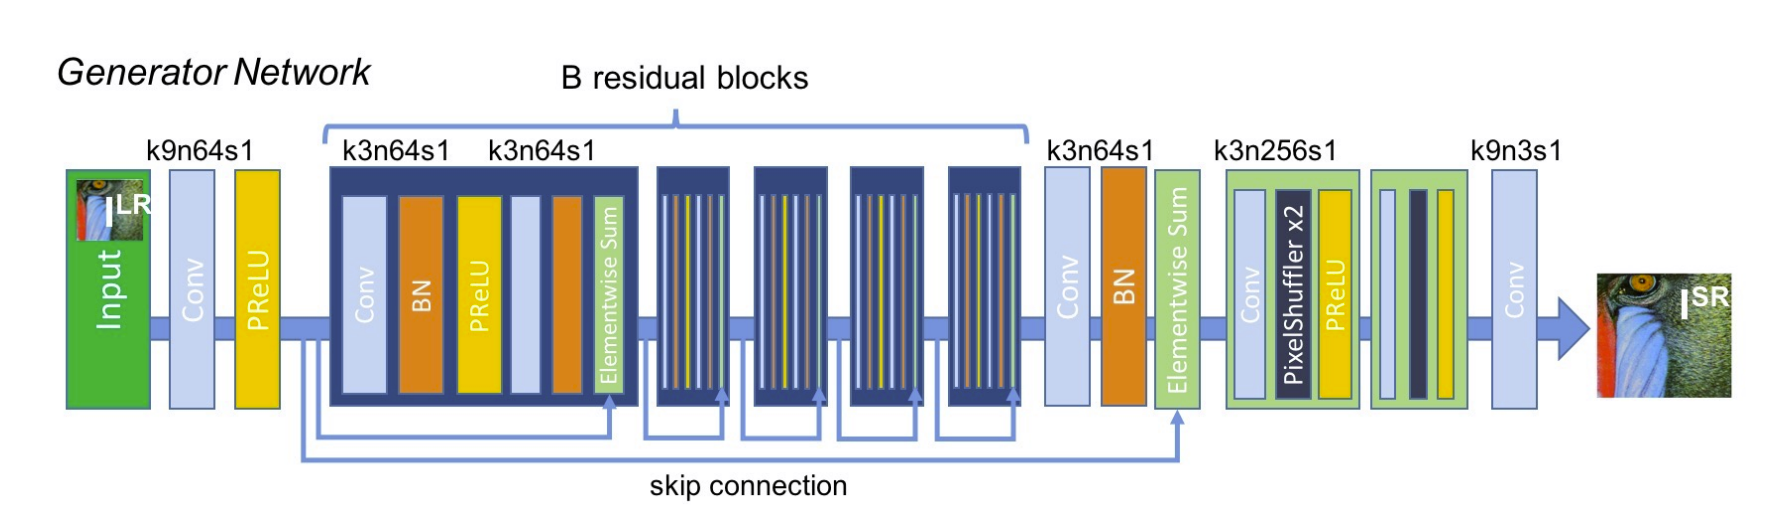

In [7]:
#model to upsampling low resolution images
#getting as input any image and giving as output image with resolution*8
def Generator():   
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    
    b_residual_block = [generator_block(64,3,name="brb"+str(i)) for i in range(16)] #16
    
    inp = tf.keras.Input(shape=[None, None, 3],
                         ragged=True)
    inp = inp.to_tensor(name='gen_input_image')
    
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=9,
                               activation='relu',
                               **conv_args)(inp)
    temp = x
    for layer in b_residual_block:
        x = tf.math.add(x, layer(temp))
        
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=3,
                               **conv_args)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.add(x, temp)
    x = pixelshuffler(
            filters=64,
            size=3)(x)
    x = pixelshuffler(
            filters=64,
            size=3)(x)
    x = pixelshuffler(
            filters=64,
            size=3)(x)
    x = tf.keras.layers.Conv2D(
        filters=3, 
        kernel_size=9,
        activation=tf.keras.activations.sigmoid,
        **conv_args)(x) 
    
    return tf.keras.Model(inputs = inp, outputs = x, name="generator")

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_32 (Conv2D)             (None, None, None,   15616       ['input_5[0][0]']                
                                64)                                                               
                                                                                                  
 brb0 (Sequential)              (None, None, None,   74368       ['conv2d_32[1][0]']              
                                64)                                                       

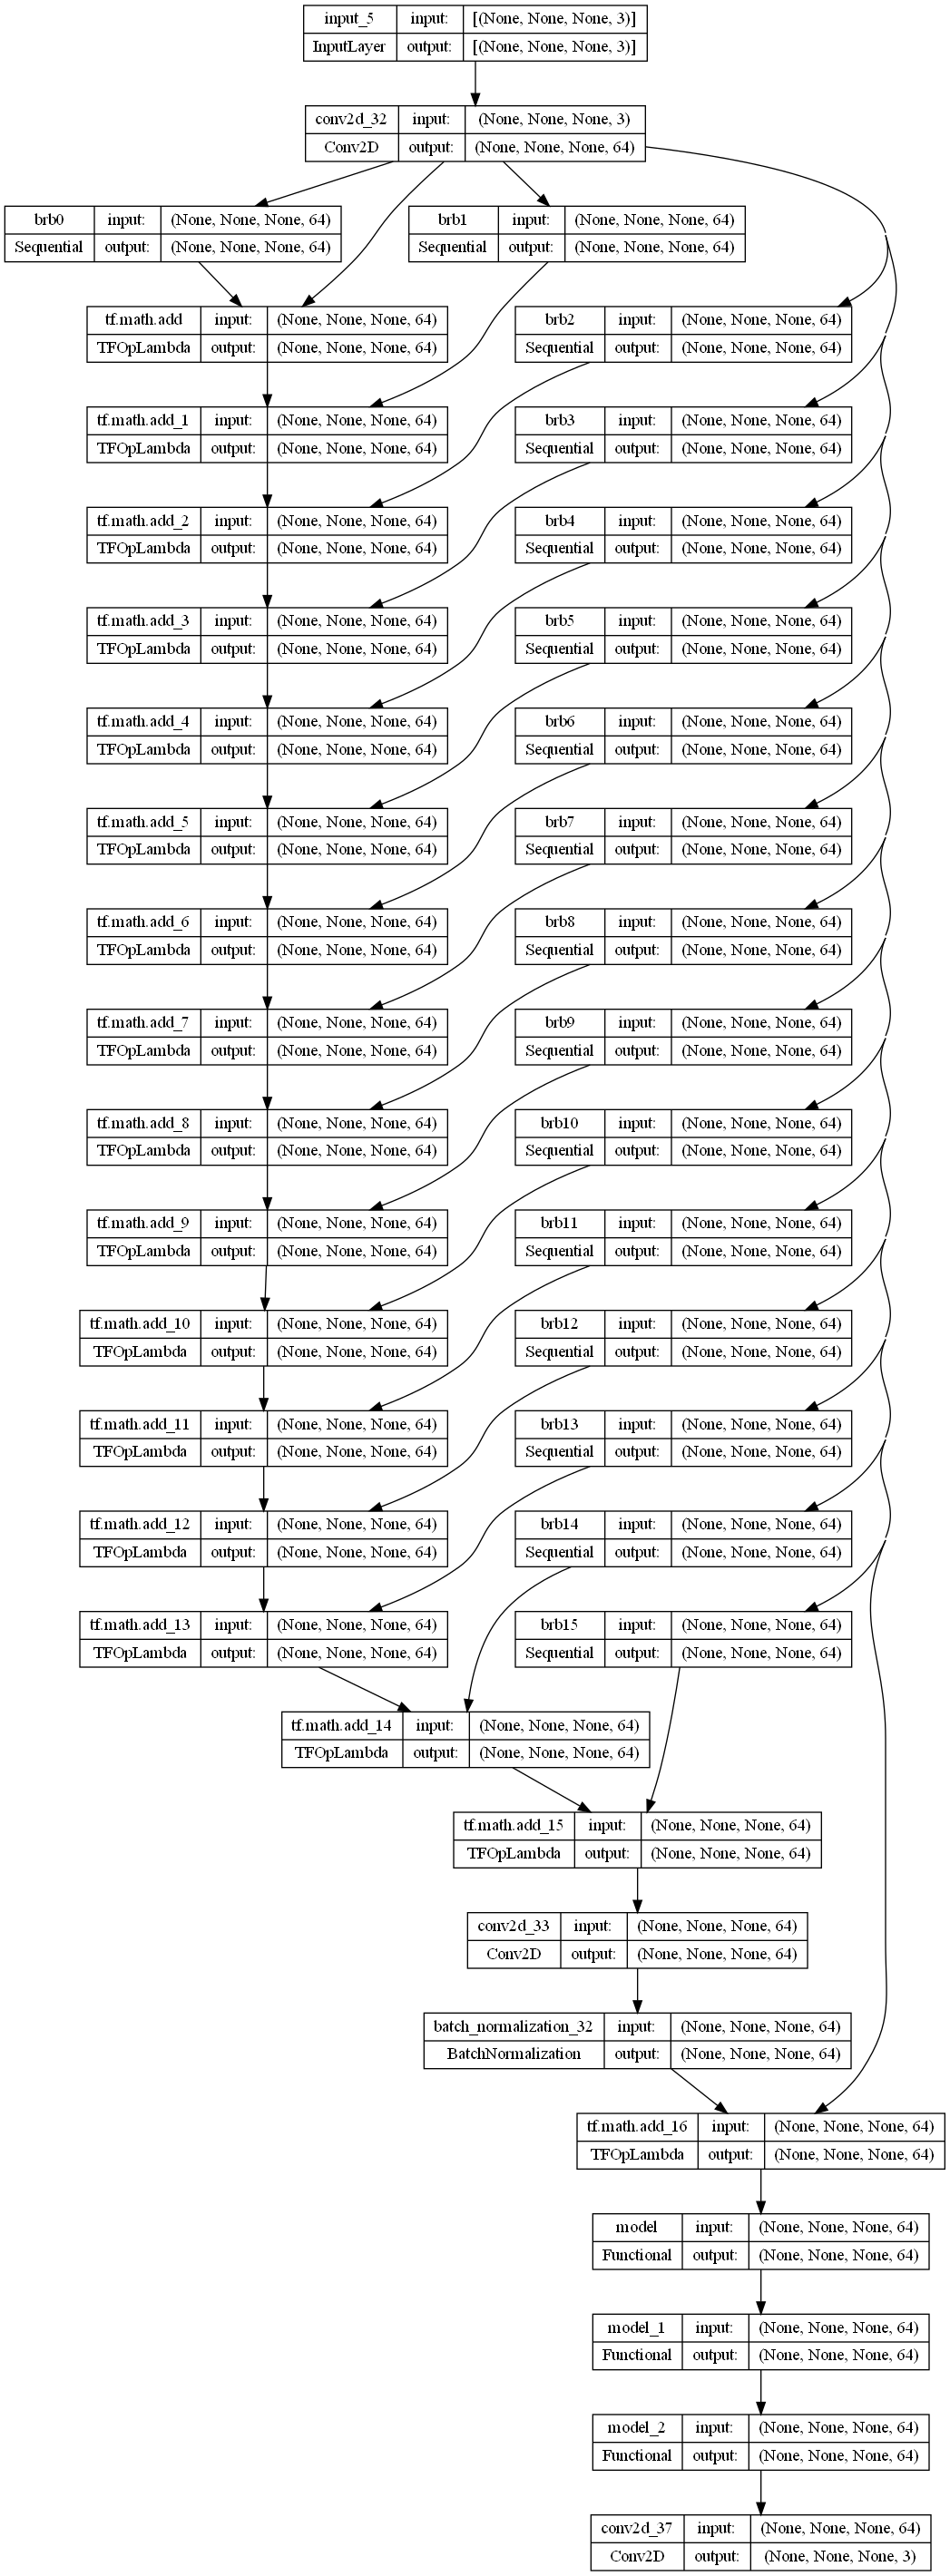

In [8]:
#initialize generator
generator = Generator()

if load_weights == True and weights_file_index != None:
    generator.load_weights(weights_folder + "generator" + weights_file_index)

#summary of trainable weight
generator.summary()
#plot the model grathp
tf.keras.utils.plot_model(generator, show_shapes = True)

**GENERATOR LOSS**

* Generator loss consists of two components
* L1 loss which is mean absolute error between the generated image and target image to make generated images structurally similar to target images
* GAN loss which is binary crossentropy loss of discriminator's output on generated images and array of ones.
* Total loss = GAN loss + (LAMBDA * L1 loss)

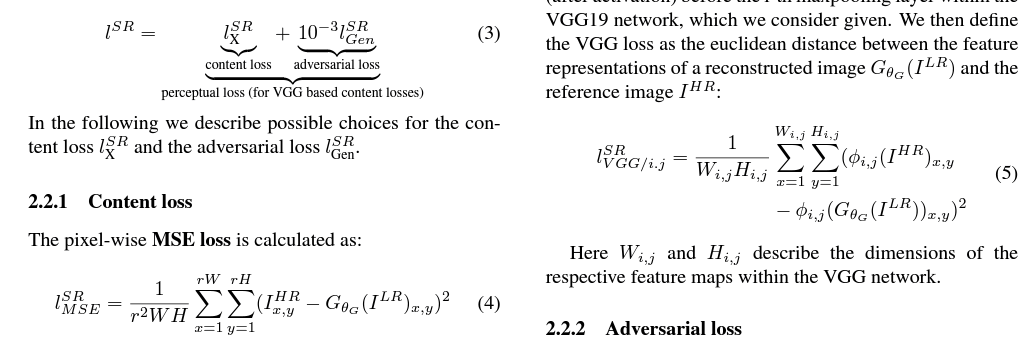
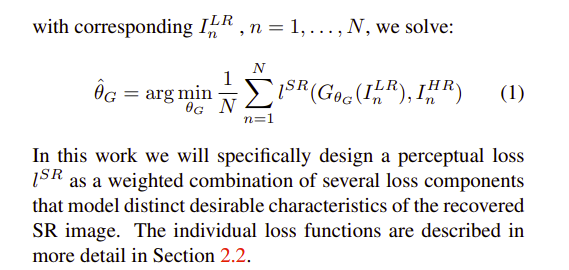

In [9]:
#for test
#adversarial_loss = tf.keras.losses.CategoricalCrossentropy()
#VGGmodel = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(512,512,3))

#declaring loss functions

def discriminator_loss(tar_img, gen_img):
    #input: B[H[W[C[0:1]]]]
    #B-Butch; H-Height; W-Width; C-Channels
    #and range of variance inside that array
    real_component = tf.reduce_mean(tar_img,1)  #B[W[C[0:1]]]
    real_component = tf.reduce_mean(real_component,1) #B[C[0:1]]
    real_component = tf.math.log(real_component)     #B[C[-∞:0]]
    gen_component = tf.reduce_mean(gen_img,1)
    gen_component = tf.reduce_mean(gen_component,1)
    gen_component = tf.math.log(tf.ones_like(gen_component) - gen_component)
    log_loss = -tf.math.reduce_min(real_component+gen_component)
    del real_component, gen_component
    return log_loss

def generator_loss(gen_output, target, dis_probability=0):
    mse_loss = tf.keras.losses.MeanSquaredError()(target, gen_output)
    adv_loss = -tf.math.reduce_min(tf.math.log(dis_probability))
    total_gen_loss = mse_loss + adv_loss*1e-2
    del mse_loss, adv_loss
    return total_gen_loss

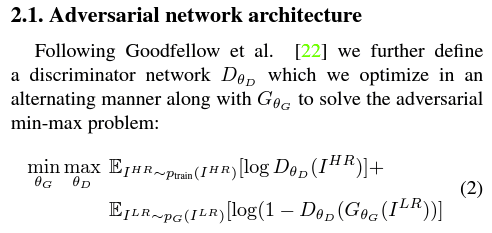

**CREATING DISCRIMINATOR MODEL**

* Discriminator model is a PatchGAN
* In a PatchGAN, the output is a 3D vector referring to similarity between patches of input and target images
* Model consists of downsampling blocks : Conv->BatchNorm->LeakyReLU
* It receives two inputs : Input image and generated image which is classified as fake and input image and target image which is classified as real

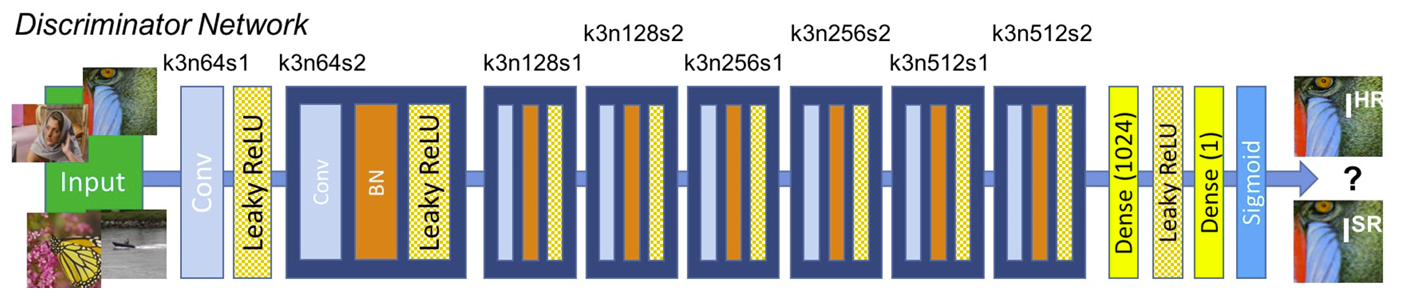


In [10]:
#repeatable discriminator part
def discriminator_block(filters, size, strides = 1):
    initializer = tf.random_normal_initializer(0. , 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides, 
                                       padding='same',
                                       kernel_initializer=initializer))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU(alpha=0.2,
                                        trainable=False))
    
    return result

#test dropout

#model for recognizing true photos among generated images
#getting an input array of images and giving an output array of values from 0 to 1 for each pixel
def Discriminator():
    #inputs = tf.keras.layers.Input(shape = [512,512,3])
    initializer = tf.random_normal_initializer(0. , 0.02)

    inputs = tf.keras.Input(shape=[None, None, 3],
                            ragged=True)
    inputs = inputs.to_tensor(name='dis_input_image')
    
    #discriminator_block
    #feature map x2 each layer, 
    #kernel 3x3, 
    #strides on every second layer that downsampling image
    down_stack = [
        tf.keras.layers.Conv2D(64,3,
                                padding='same',
                                kernel_initializer = initializer),
        tf.keras.layers.LeakyReLU(alpha=0.2,
                                 trainable=False),
        discriminator_block(64, 3, 2), 
        discriminator_block(128, 3, 1),
        discriminator_block(128, 3, 2),
        discriminator_block(256, 3, 1),
        discriminator_block(256, 3, 2), 
        discriminator_block(512, 3, 1), 
        discriminator_block(512, 3, 2),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.LeakyReLU(alpha=0.2,
                                 trainable=False),
        tf.keras.layers.Dense(1),
        tf.math.sigmoid,
    ]
    x = inputs
    for down in down_stack:
        x = down(x)
    #x = tf.reduce_mean(x,1)
    #x = tf.reduce_mean(x,1)
    return tf.keras.Model(inputs = inputs, outputs = x, name="discriminator")

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_38 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 64)    0         
                                                                 
 sequential (Sequential)     (None, None, None, 64)    37184     
                                                                 
 sequential_1 (Sequential)   (None, None, None, 128)   74368     
                                                                 
 sequential_2 (Sequential)   (None, None, None, 128)   148096    
                                                                 
 sequential_3 (Sequential)   (None, None, None, 256) 

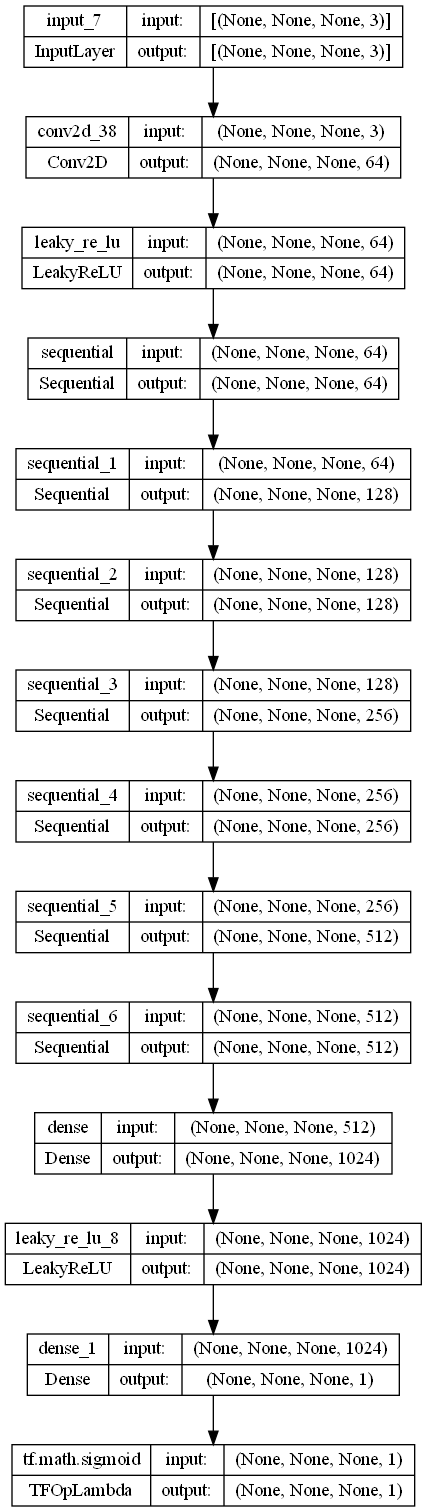

In [11]:
#initializing discriminator
discriminator = Discriminator()

if load_weights == True and weights_file_index != None:
    discriminator.load_weights(weights_folder + "discriminator" + weights_file_index)

#summary of trainable variables
discriminator.summary()
#plot the modle grathp
tf.keras.utils.plot_model(discriminator, show_shapes=True)

**DISCRIMINATOR LOSS**

* It takes two inputs : discriminator output for real images and generated images and it has two components : real loss and generated loss
* real loss is sigmoid cross entropy loss of real image output and array of ones
* generated loss is sigmoid cross entropy loss of generated image output and array of zeros
* total loss is sum of real loss and generated loss

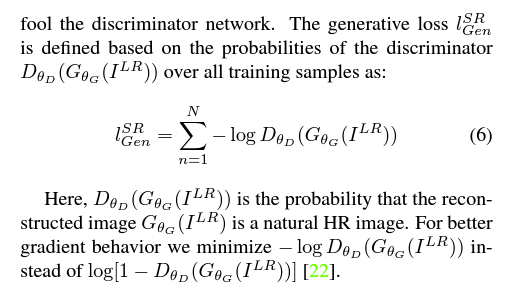

**OPTIMIZERS AND CHECKPOINT SAVER**

In [12]:
#initialization and tuning of problem optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.9)
#model saves manager
checkpoint_dir = "./training_checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir , max_to_keep=10)

    https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
    https://www.tensorflow.org/guide/data
    dataset3 = tf.data.Dataset.zip((dataset1, dataset2))


**TRAINING**

In [18]:
#number of iterations
EPOCHS = 9
#limit the dataset images to train model with
LIMIT = None

if resotre_weights: checkpoint.restore(ckpt_manager.latest_checkpoint)

#model of training the models
#@tf.function
def fit(hr_input, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        counter = 1
        gen_loss_sum = 0
        dis_loss_sum = 0
        for batch in hr_input:
            with tf.GradientTape() as g_tape:
                gen_output = generator(tf.image.resize(batch,(64,64)), training = True)
                
                dis_prediction = discriminator(gen_output, training = False)

                gen_loss = generator_loss(gen_output, batch, dis_prediction)  
                gen_loss_sum += gen_loss
                del gen_output, dis_prediction
            with tf.GradientTape() as d_tape:
                gen_output = generator(tf.image.resize(batch,(64,64)), training = False)
                
                dis_real_output = discriminator(batch, training = True)
                dis_gen_output = discriminator(gen_output, training = True)
                
                dis_loss = discriminator_loss(dis_real_output, dis_gen_output)
                dis_loss_sum += dis_loss
                del gen_output, dis_real_output, dis_gen_output
            counter += 1
            print(f"{'t:'+str(int(1749*(time.time()-start_time)/counter - (time.time()-start_time))):<6} EP:{epoch+1} GL:{gen_loss_sum/counter:.4f} DL:{dis_loss_sum/counter:.4f}", end="\r") #GP:{tf.reduce_mean(disc_gen_output):.2f} RP:{tf.reduce_mean(disc_real_output):.2f}", end="\r")
        #apply generator gradient at the end of epoch
        gen_grads = g_tape.gradient(gen_loss_sum, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
        #apply discriminator gradient at the end of epoch
        dis_grads = d_tape.gradient(dis_loss_sum, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(dis_grads, discriminator.trainable_variables)) 
        #save, next statistic line, clear some memory
        ckpt_manager.save()
        print()
        del gen_grads, dis_grads

#run training
#mode 2 is a custom model
#mode 3 is a tensorflow basic approach
if TRAINING == True:
    mode = 2
    if mode == 2:
        if LIMIT: fit(train_ds.take(LIMIT), EPOCHS)
        else: fit(train_ds, EPOCHS)
    if mode == 3:
        generator.compile(optimizer=generator_optimizer, 
                          loss='mse',
                          metrics=['mae', 'msle'])
        
        generator.fit(tf.data.Dataset.zip((train_ds.map(lambda x: tf.image.resize(x,(64,64))), 
                                           train_ds)),
                      epochs=EPOCHS)
        ckpt_manager.save()

t:0    EP:1 GL:0.0210 DL:1.1264
t:0    EP:2 GL:0.0217 DL:1.1259
t:0    EP:3 GL:0.0223 DL:1.1254
t:0    EP:4 GL:0.0240 DL:1.1290
t:0    EP:5 GL:0.0253 DL:1.1307
t:0    EP:6 GL:0.0255 DL:1.1269
t:0    EP:7 GL:0.0244 DL:1.1230
t:0    EP:8 GL:0.0242 DL:1.1180
t:0    EP:9 GL:0.0237 DL:1.1136


(1, 3096, 3320, 3)


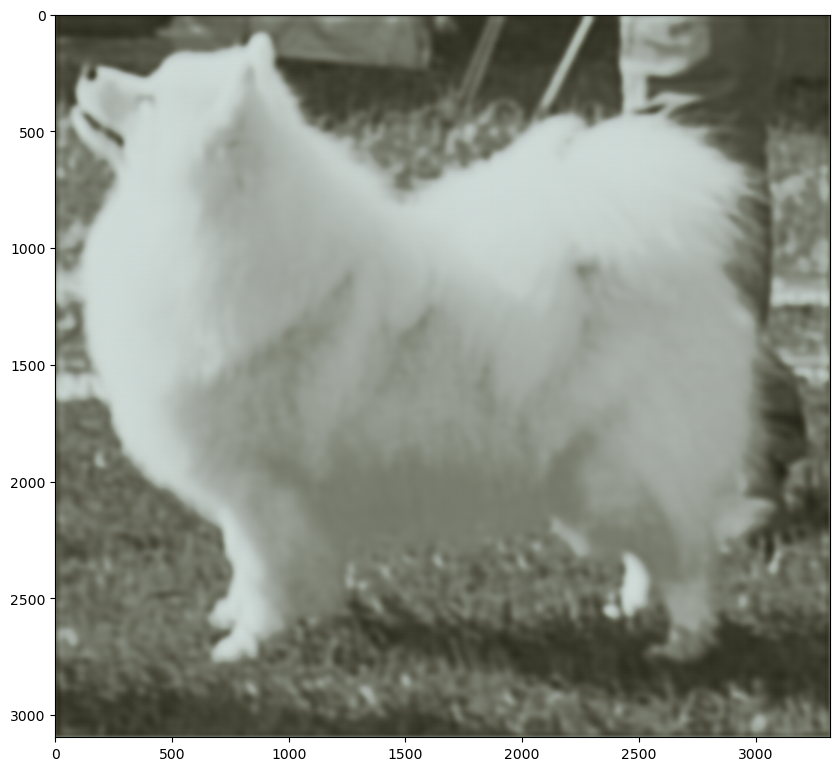

In [21]:
#selected test images processing generator and will be saved at preset folder
TEST_IMAGE_PATH = r"C:\Users\common\Pictures\spitz\input.jpg"
OUTPUT_SAVE_DIRECTORY = "C:/Users/common/Pictures/spitz/"

#choosing CPU devica because GPU resources are not freed after training
with tf.device('/CPU:0'):
    filename_input = TEST_IMAGE_PATH
    test_image = Image.open(filename_input)
    np_array_image = np.array([test_image])/255.
    result = generator(np_array_image)
    name = OUTPUT_SAVE_DIRECTORY+"generated_output_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+".jpg"
    visualize(result)
    result = result.numpy()[0]*255
    result = Image.fromarray(result.astype(np.uint8))
    result.save(name)

(2, 512, 512, 3)


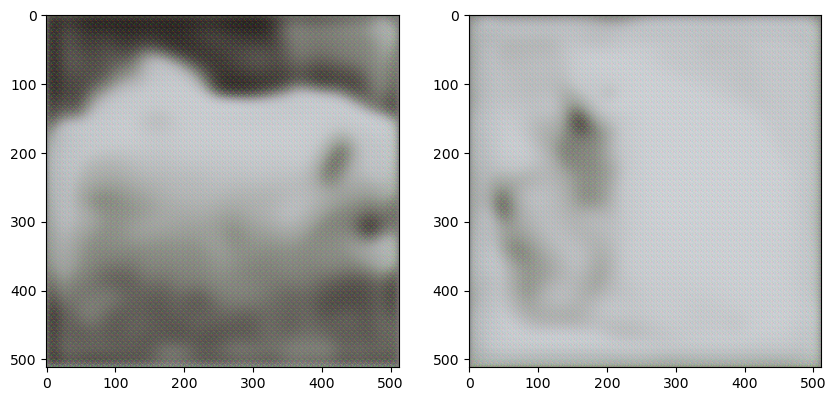

In [16]:
with tf.device('/CPU:0'):
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    input_sample = tf.image.resize(test_sample,(64,64))
    output_sample = generator(input_sample)# * 255
    output_sample = output_sample.numpy()#.astype(np.uint8)
    visualize(output_sample)

In [ ]:
if False:
    postfix = "_main"
    
    discriminator.save_weights(weights_folder + 'discriminator' + postfix)
    generator.save_weights(weights_folder + 'generator' + postfix)

    print("files:\n",
         weights_folder + 'discriminator' + postfix,"\n",
         weights_folder + 'generator' + postfix)
